In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from matplotlib import font_manager, rc
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

# 한글 폰트 설정
font_path = r"C:\Windows\Fonts\batang.ttc"
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)
print(f"설정된 폰트: {font_name}")

# 경로 설정
base_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
data_dir = os.path.join(base_dir, 'data')
processed_dir = os.path.join(data_dir, 'processed')
saved_model_dir = os.path.join(base_dir, 'saved_models')
file_path = os.path.join(processed_dir, 'daily_average_price_volume_by_product_seoul.csv')

# 데이터 로드
if not os.path.exists(file_path):
    raise FileNotFoundError(f"Data file not found at {file_path}")
data = pd.read_csv(file_path)

설정된 폰트: Batang


In [2]:
# 컬럼명 매핑
column_mapping = {
    '일자': 'date',
    '품목': 'product',
    '평균단가': 'average_price',
    '총물량': 'volume',
    '평균기온(°C)': 'avg_temp',
    '최저기온(°C)': 'min_temp',
    '최고기온(°C)': 'max_temp',
    '일강수량(mm)': 'precipitation'
}
data.rename(columns=column_mapping, inplace=True)

# 데이터 전처리
data['date'] = pd.to_datetime(data['date'])
data = data.sort_values(['product', 'date'])

In [3]:
# 시각화 함수
def visualize_predictions(product_name):
    product_data = data[data['product'] == product_name]

    # 필요한 컬럼 선택 및 결측치 처리
    data_subset = product_data[['date', 'average_price', 'volume']]
    data_subset = data_subset.ffill().bfill()

    # 스케일링
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data_subset[['average_price', 'volume']])

    # 시계열 데이터 생성 함수
    def create_sequences(data, seq_length):
        X, y = [], []
        for i in range(len(data) - seq_length):
            X.append(data[i:i+seq_length, :])
            y.append(data[i+seq_length, 0])
        return np.array(X), np.array(y)

    sequence_length = 30
    X, y = create_sequences(scaled_data, sequence_length)

    # 각 폴드 모델 로드 및 예측
    predictions = []
    mse_scores = []
    tscv = TimeSeriesSplit(n_splits=5)
    fold = 1
    for train_index, test_index in tscv.split(X):
        X_test, y_test = X[test_index], y[test_index]

        model_path = os.path.join(saved_model_dir, f'{product_name}_fold{fold}_model.keras')
        if not os.path.exists(model_path):
            raise FileNotFoundError(f"Model file not found: {model_path}")

        model = load_model(model_path)
        pred = model.predict(X_test).flatten()  # 1D 배열로 변환
        predictions.append(pred)

        # MSE 계산
        mse = mean_squared_error(y_test, pred)
        mse_scores.append(mse)
        fold += 1

    # 평균 예측 계산
    avg_predictions = np.hstack(predictions)

    # 테스트 데이터 복원
    test_indices = np.concatenate([test_index for _, test_index in tscv.split(X)])
    test_dates = data_subset['date'].iloc[test_indices + sequence_length].values
    actual_prices = y[test_indices]

    # 평균 MSE 출력
    mean_mse = np.mean(mse_scores)
    print(f"Mean MSE for {product_name}: {mean_mse:.4f}")

    # 시각화
    plt.figure(figsize=(12, 6))
    plt.plot(test_dates, scaler.inverse_transform(np.c_[actual_prices, np.zeros_like(actual_prices)])[:, 0], label='Actual Price', color='blue')
    plt.plot(test_dates, scaler.inverse_transform(np.c_[avg_predictions, np.zeros_like(avg_predictions)])[:, 0], label='Predicted Price (Avg of 5 Folds)', color='red')
    plt.title(f"Price Forecasting for {product_name}")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid()
    plt.show()


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step
Mean MSE for 고구마: 0.0028


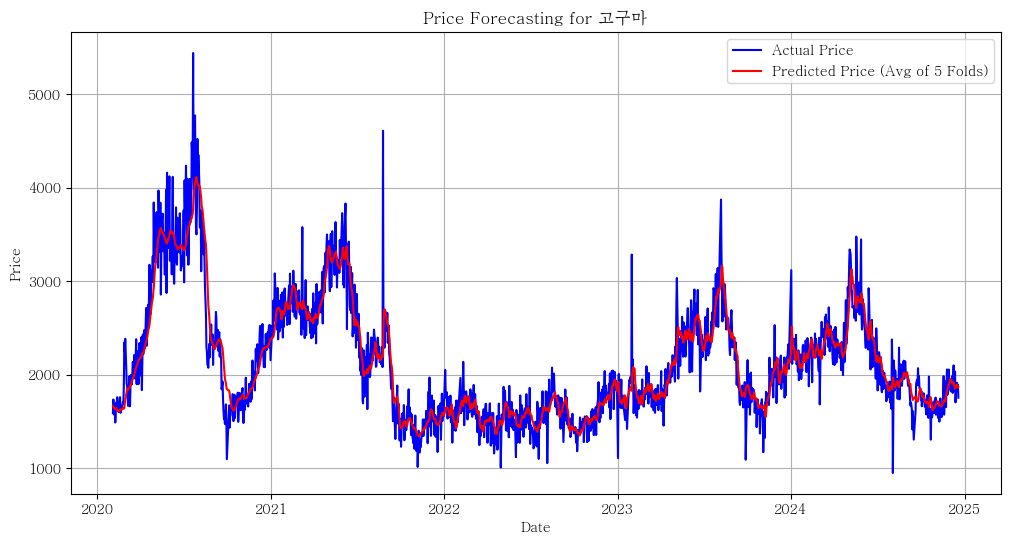

In [6]:
visualize_predictions('고구마')